In [1]:
import matplotlib.pyplot as plt
import numpy as np
import imageio as io
import cv2
import pathlib
from pyometiff import OMETIFFReader
import imageio as io
from __future__ import print_function
import scanpy as sc
import os
import pandas as pd
import PIL
from tqdm.notebook import tqdm
import glob

#### This last script will use the GAN predictions to align the HE with the Xenium DAPI. In summary, we converted the HE image to what the corresponding DAPI image likely looks like. And we are warping this "likely" DAPI image to fit the Xenium DAPI.

Enter the path to the HE and Xenium output

In [2]:
path_to_HE_ome = '/projects/2023_Spatial_Paper/data/HE_timecourse/OMETIFF/d6_SI_r2.ome.tif'
xenium_path = '/mnt/sata1/Analysis_Alex/timecourse_replicates/day6_SI_r2/xenium_output'

In [3]:
img_array_HE_orig = io.imread_v2(path_to_HE_ome)
h_and_e  = img_array_HE_orig.astype(np.uint16)

#### Read in the predicted images and stitch them together

In [4]:
conversion_path = '/home/amonell/piloting/pytorch-CycleGAN-and-pix2pix/results/histology_pix2pix/test_latest/images'

predictions = glob.glob(os.path.join(conversion_path, '*fake*'))

file_paths = predictions

sorted_file_paths = sorted(file_paths, key=lambda x: int(x.split('_')[-3]))

all_rows = []
counter = 0
for row in tqdm(range(256, np.shape(h_and_e)[0] + 256, 256)):
    current_row = []
    for col in range(256, np.shape(h_and_e)[1] + 256, 256):
        current_row.append(io.imread(sorted_file_paths[counter]))
        counter += 1
    all_rows.append(np.hstack(current_row))
    
all_rows = np.vstack(all_rows)
img_array_IF_orig = all_rows[:, :, 0][:np.shape(img_array_HE_orig)[0], :np.shape(img_array_HE_orig)[1]]
    

  0%|          | 0/114 [00:00<?, ?it/s]

/tmp/ipykernel_1928171/1820715460.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  current_row.append(io.imread(sorted_file_paths[counter]))


### Downsize the predicted DAPI and Xenium DAPI

In [5]:
channel_display = 0
down_factor = 10

new_width = int(img_array_IF_orig.shape[0] / down_factor)
new_height = int(img_array_IF_orig.shape[1] / down_factor)
# Normalize the image to the range [0, 1]
normalized_image = img_array_IF_orig

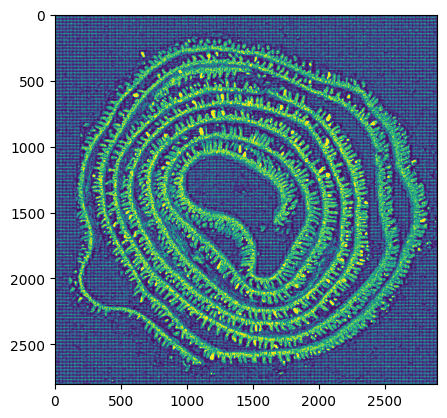

In [6]:
# Resize the image
thumbnail = cv2.resize(normalized_image, (new_width, new_height))
plt.imshow(thumbnail, vmax=np.percentile(thumbnail, 95))

In [7]:

img_array_IF = normalized_image
downscale_factor_IF = 3

pad_height = (downscale_factor_IF - img_array_IF.shape[0] % downscale_factor_IF) % downscale_factor_IF
pad_width = (downscale_factor_IF - img_array_IF.shape[1] % downscale_factor_IF) % downscale_factor_IF

# Pad the array with zeros
padded_IF = np.pad(img_array_IF, ((0, pad_height), (0, pad_width)), mode='constant')

new_width = int(padded_IF.shape[1] / downscale_factor_IF)
new_height = int(padded_IF.shape[0] / downscale_factor_IF)

# Resize the image
resized_image = cv2.resize(padded_IF, (new_width, new_height))
IF_image = resized_image

In [8]:

img_fpath = pathlib.Path(os.path.join(xenium_path, 'morphology_mip.ome.tif'))

reader = OMETIFFReader(fpath=img_fpath)

img_array_xenium, metadata_xenium, xml_metadata = reader.read()

Key not found: 'NoneType' object has no attribute 'iter'
Key not found: 'NoneType' object has no attribute 'iter'


In [9]:
img_array_xenium = 255*(img_array_xenium/np.max(img_array_xenium))

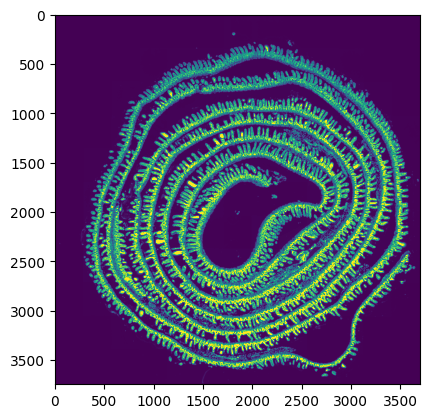

In [10]:
down_factor = 10

new_width = int(img_array_xenium.shape[1] / down_factor)
new_height = int(img_array_xenium.shape[0] / down_factor)

# Resize the image
thumbnail = cv2.resize(img_array_xenium, (new_width, new_height))
plt.imshow(thumbnail, vmax=np.percentile(thumbnail, 95))

In [11]:
downscale_factor = 3
# Calculate the amount of padding needed for each axis
pad_height = (downscale_factor - img_array_xenium.shape[0] % downscale_factor) % downscale_factor
pad_width = (downscale_factor - img_array_xenium.shape[1] % downscale_factor) % downscale_factor

# Pad the array with zeros
padded_array = np.pad(img_array_xenium, ((0, pad_height), (0, pad_width)), mode='constant')

# Now 'padded_array' will have both axes sizes divisible by 2
img_array_xenium = padded_array

new_width = int(img_array_xenium.shape[1] /downscale_factor) 
new_height = int(img_array_xenium.shape[0] / downscale_factor)

# Resize the image
resized_xenium = cv2.resize(img_array_xenium, (new_width, new_height))


#### Align the predicted DAPI with the actual DAPI

In [12]:
over_constant = 256/downscale_factor_IF
#max number of corners to detect in each image
MAX_FEATURES = 10000
#percent of corner patches to keep
GOOD_MATCH_PERCENT = 0.15
#how much to blur the initial images to capture villi structure keypoints
blur_res_IF = (1, 1)
blur_res_xen = (1, 1)


def alignImages(im1, im2):

    print('keypoint detection...')
    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES, patchSize= 100)
    keypoints1, descriptors1 = orb.detectAndCompute(im1, None)
    keypoints1_ = [point.pt for point in keypoints1]
    keypoints1_sizes = [point.size for point in keypoints1]
    keypoints1_angles = [point.angle for point in keypoints1]
    #filtered_keypoints = np.array([(p[0], p[1]) for p in keypoints1_ if ((((p[0]%over_constant) > 0) & (p[1]%over_constant > 0)) & (abs(p[0]/over_constant - round(p[0]/over_constant)) > 0.15) & (abs(p[1]/over_constant - round(p[1]/over_constant)) > 0.15))])
    ids = np.array([i for i, p in enumerate(keypoints1_) if ((abs(p[0]/over_constant - round(p[0]/over_constant)) > 0.15) & (abs(p[1]/over_constant - round(p[1]/over_constant)) > 0.15))])
    
    positions_array = np.array([point.pt for point in keypoints1])[ids]
    sizes_array = np.array(keypoints1_sizes)[ids]
    angles_array = np.array(keypoints1_angles)[ids]

    descriptors1 = np.array(descriptors1)[ids]
    keypoints1 = []
    for i in range(len(positions_array)):
        keypoints1.append(cv2.KeyPoint(positions_array[i][0], positions_array[i][1], size=sizes_array[i], angle = angles_array[i]))

    keypoints2, descriptors2 = orb.detectAndCompute(im2, None)
    print(len(keypoints1))
    print(len(keypoints2))
    print('feature matching...')
    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
    matches = list(matches)
    print(len(matches))
    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    print('prune bad matches...')
    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
    print(len(matches))
    # Draw top matches
    # imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    # plt.figure(dpi=200)
    # plt.imshow(imMatches)
    # plt.show()
    # cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h, keypoints1, keypoints2
 

print("Aligning images ...")
# Registered image will be resotred in imReg.
# The estimated homography will be stored in h.
imReg, h, keypoints1, keypoints2 = alignImages(cv2.blur(((resized_image/np.max(resized_image))*255).astype(np.uint8), blur_res_IF), cv2.blur(((resized_xenium/np.max(resized_xenium))*255).astype(np.uint8), blur_res_xen))

# Print estimated homography
print("Estimated homography : \n",  h)

Aligning images ...
keypoint detection...
4767
10000
feature matching...
4767
prune bad matches...
715
Estimated homography : 
 [[ 7.89293983e-03  1.28563408e+00  1.75288134e+02]
 [-1.28177959e+00  8.38540752e-03  1.26212814e+04]
 [ 5.73772223e-08  1.99423702e-07  1.00000000e+00]]


In [13]:
height, width = resized_xenium.shape
im1Reg = cv2.warpPerspective(resized_image, h, (width, height))

new_width = int(im1Reg.shape[1] *downscale_factor_IF) 
new_height = int(im1Reg.shape[0] *downscale_factor_IF)

# Resize the image
warped = cv2.resize(im1Reg, (new_width, new_height))

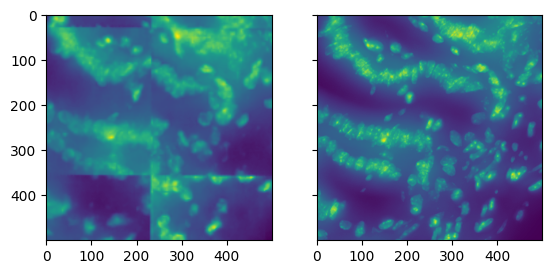

In [14]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.imshow(warped[10000:10500, 10000:10500])
ax2.imshow(img_array_xenium[10000:10500, 10000:10500])
plt.show()
#downsize for diplay before this
# fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
# ax1.imshow(warped)
# ax2.imshow(img_array_xenium)
# plt.show()

#### Show the keypoints from both images

In [15]:
plot_keys =[]
for t in range(len(keypoints1)):
    x = keypoints1[t].pt[0]
    y = keypoints1[t].pt[1]
    plot_keys.append([x, y])
plot_keys = np.array(plot_keys)

plot_keys2 =[]
for t in range(len(keypoints2)):
    x = keypoints2[t].pt[0]
    y = keypoints2[t].pt[1]
    plot_keys2.append([x, y])
plot_keys2 = np.array(plot_keys2)

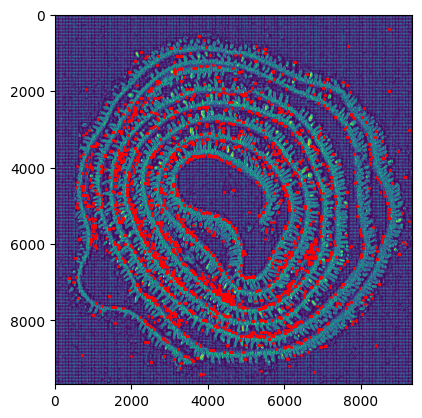

In [16]:
plt.imshow(cv2.blur(((resized_image/np.max(resized_image))*255).astype(np.uint8), blur_res_IF))
plt.scatter(plot_keys[:, 0], plot_keys[:, 1], s=1, c='red')
plt.show()

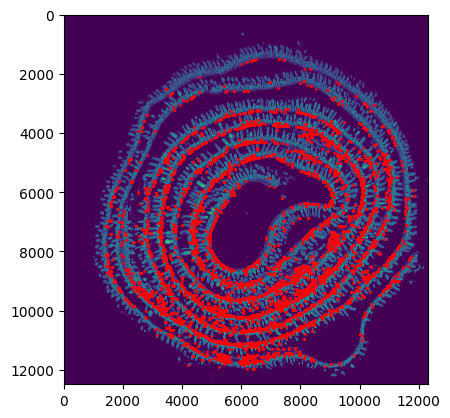

In [17]:
plt.imshow(cv2.blur(resized_xenium.astype(np.uint8), blur_res_xen))
plt.scatter(plot_keys2[:, 0], plot_keys2[:, 1], s=1, c='red')
plt.show()

### Aligning high quality H&E with low quality aligned H&E

In [18]:

img_array_HE2 = normalized_image
downscale_factor = 1

pad_height = (downscale_factor - img_array_HE2.shape[0] % downscale_factor) % downscale_factor
pad_width = (downscale_factor - img_array_HE2.shape[1] % downscale_factor) % downscale_factor

# Pad the array with zeros
padded_HE2 = np.pad(img_array_HE2, ((0, pad_height), (0, pad_width)), mode='constant')

new_width = int(padded_HE2.shape[1] / downscale_factor)
new_height = int(padded_HE2.shape[0] / downscale_factor)

# Resize the image
resized_image2 = cv2.resize(padded_HE2, (new_width, new_height))
HE_image2 = resized_image2

In [19]:
downscale_factor = 2
# Calculate the amount of padding needed for each axis
pad_height = (downscale_factor - warped.shape[0] % downscale_factor) % downscale_factor
pad_width = (downscale_factor - warped.shape[1] % downscale_factor) % downscale_factor

# Pad the array with zeros
padded_array = np.pad(warped, ((0, pad_height), (0, pad_width)), mode='constant')

# Now 'padded_array' will have both axes sizes divisible by 2
warped = padded_array

new_width = int(warped.shape[1] /downscale_factor) 
new_height = int(warped.shape[0] / downscale_factor)

# Resize the image
resized_warped = cv2.resize(warped, (new_width, new_height))


In [20]:
#max number of corners to detect in each image
MAX_FEATURES = 4000
#percent of corner patches to keep
GOOD_MATCH_PERCENT = 0.5
#how much to blur the initial images to capture villi structure keypoints
blur_res = (5, 5)


def alignImages(im1, im2):

    print('keypoint detection...')
    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES, patchSize= 100)
    keypoints1, descriptors1 = orb.detectAndCompute(im1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2, None)
    print(len(keypoints1))
    print(len(keypoints2))
    print('feature matching...')
    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
    matches = list(matches)
    print(len(matches))
    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    print('prune bad matches...')
    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
    print(len(matches))
    # Draw top matches
    # imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    # plt.figure(dpi=200)
    # plt.imshow(imMatches)
    # plt.show()
    #cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    print('warping')
    # Use homography
    height, width = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h
 

print("Aligning images ...")
# Registered image will be resotred in imReg.
# The estimated homography will be stored in h.
imReg, h = alignImages(cv2.blur(((resized_image2/np.max(resized_image2))*255).astype(np.uint8), blur_res)[:32766, :32766], resized_warped)

# Print estimated homography
print("Estimated homography : \n",  h)

Aligning images ...
keypoint detection...
4000
4000
feature matching...
4000
prune bad matches...
2000
warping
Estimated homography : 
 [[ 3.95619902e-03  6.42883633e-01  2.62333189e+02]
 [-6.40912609e-01  4.21608279e-03  1.89328186e+04]
 [ 2.05115679e-08  6.89485780e-08  1.00000000e+00]]


In [21]:
height, width = warped.shape
im1Reg = cv2.warpPerspective(resized_image2[:32766, :32766], h, (width, height))

new_width = int(im1Reg.shape[1] *downscale_factor) 
new_height = int(im1Reg.shape[0] *downscale_factor)

# Resize the image
warped2 = cv2.resize(im1Reg, (new_width, new_height))

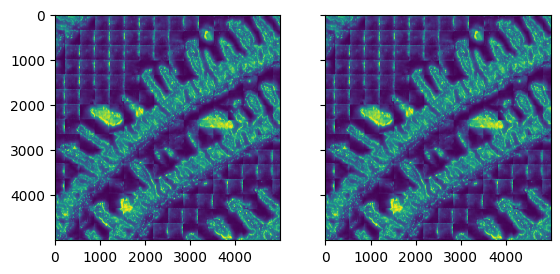

In [22]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.imshow(warped2[10000:15000, 10000:15000])
ax2.imshow(warped[10000:15000, 10000:15000])
plt.show()

#### Use the alignment homography matrix to warp actual H&E images to match the Xenium DAPI

In [23]:
orig_he = io.imread_v2(path_to_HE_ome)
he_stack = []
for i in [0, 1, 2]: 
    try:
        height, width = warped.shape
        im1Reg = cv2.warpPerspective(orig_he[:,:, i], h, (width, height))

        new_width = int(im1Reg.shape[1] *downscale_factor) 
        new_height = int(im1Reg.shape[0] *downscale_factor)

        # Resize the image
        warped2 = cv2.resize(im1Reg, (new_width, new_height))
        warped_H_and_E = warped2[:np.shape(img_array_xenium)[0], :np.shape(img_array_xenium)[1]]
        he_stack.append(warped_H_and_E)
    except:
        print(f'Channel {i} is not in this image')

In [24]:
transformed_h_and_e = np.dstack(he_stack)

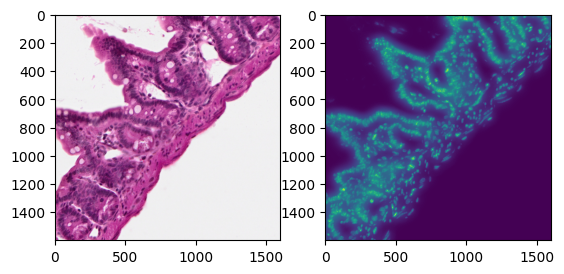

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(transformed_h_and_e[9500:11100, 9500:11100])
ax2.imshow(img_array_xenium[9500:11100, 9500:11100])
plt.show()

In [127]:
np.save(os.path.join(os.path.dirname(xenium_path), 'h_and_e_alignment_gan.npy'), transformed_h_and_e)